In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

In [2]:
from tqdm import tqdm
tqdm.pandas()

# Алгоритм для вычисления корреляционной размерности

## Функция для определения range epsilon

In [3]:
def establish_epsilon_range(text_embedding):

    # находим все попарные рсстояния между точками (евклидово расстояние)
    distances = np.array(pdist(text_embedding, 'euclidean'))

    # определяем шаг, создаем список из log(epsilon)
    epsilon_range = np.linspace(min(distances)+0.00001, 15, 1000)
    epsilon_range_log = [np.log(i) for i in epsilon_range]

    # возвращаем попарные расстояния, список epsilon и список log(epsilon)
    return distances, epsilon_range, epsilon_range_log

## Функция для рассчета корреляционного интеграла (C)

In [4]:
def get_C_log(distances, epsilon_range):

    # для всех epsilon находим отношение числа расстояний,
    # меньших epsilon, к полному числу пар
    c_d =  np.array([np.mean(distances < eps) for eps in epsilon_range])
    c_log = [np.log(i) for i in c_d]

    return c_log

## Функция для нахождения углового коэффициента

In [5]:
def lin_reg(X, Y):

    # обрезаем часть графика, которая содержится между y = -9 и y = -2
    # для вычисления размерности аттрактора Лоренца

    #X_trimmed = [x_i for x_i, y_i in zip(X, Y) if -9 <= y_i <= -2]
    #Y_trimmed = [y_i for y_i in Y if -9 <= y_i <= -2]

    # обрезаем часть графика, которая содержится между y = -4 и y = -1
    # для вычисления размерности текстов
    X_trimmed = [x_i for x_i, y_i in zip(X, Y) if -4 <= y_i <= -1]
    Y_trimmed = [y_i for y_i in Y if -4 <= y_i <= -1]

    # линейная регрессия
    slope = np.polyfit(X_trimmed, Y_trimmed, 1)[0]

    # возвращаем угл. коэф.
    return slope

##  Функция для отрисовки графиков

In [6]:
def make_graph(X, Y, ):

    plt.plot(X, Y, label=f"ln C(e) ~ ln e /1000")
    plt.xlabel("log(epsilon)")
    plt.ylabel("log C(epsilon)")
    plt.legend()
    plt.title("C(epsilon) vs. log(epsilon)")
    plt.show()

    pass

## Функция для запуска алгоритма

In [7]:
# для единственной размерности данных
def calculate_1_dimension(embedding, n=6):
    embedding = [word_vector[:n+1] for word_vector in embedding]
    try:
        dist, eps_range, eps_range_log = establish_epsilon_range(embedding)
        c_log = get_C_log(dist, eps_range)
        #make_graph(eps_range_log, c_log)
    except Exception as e:
        print(e)
        return None
    return lin_reg(eps_range_log, c_log)

In [8]:
# для нескольких размерностей
def calculate_several_dimensions(
    embedding, lowest_number_dim=50, highest_number_dim=100):

    dimensions = []
    embedding = np.array(embedding)
    for i in range(lowest_number_dim, highest_number_dim+1, 50):
        current_embedding = [word_vector[:i] for word_vector in embedding]
        try:
            dist, eps_range, eps_range_log = establish_epsilon_range(current_embedding)
            c_log = get_C_log(dist, eps_range)
            dimensions.append(lin_reg(eps_range_log, c_log))
            #make_graph(eps_range_log, c_log)
        except Exception as e:
            print(e)
            return None
    return dimensions

# Тестирование алгоритма

## Рассчет корреляционной размерности аттрактора Лоренца

Корреляционная размерность для аттрактора Лоренца составляет ~2,06. Оценим ее с помощью нашего алгоритма, чтобы проверить качество его работы.

In [ ]:
from scipy.integrate import odeint

# уравнения для задания аттрактора Лоренца со стандартными параметрами
def lorenz_system(u, t, sigma=10, rho=28, beta=8/3):
    x, y, z = u
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

initial_conditions = [1.0, 0.0, 0.0]
t = np.arange(0, 1000, 0.1)
solution = odeint(lorenz_system, initial_conditions, t)

In [ ]:
calculate_1_dimension(solution)

# Обработка датафрейма

## Рассчет размерности

In [43]:
df = pd.read_pickle("final_text_df_with_bigram_6.pkl")
df_cleaned = df.dropna(subset=['embeddings'], how='any').copy()

In [ ]:
df = pd.read_pickle("final_text_df_with_trigram_6.pkl")
df_cleaned = df.dropna(subset=['embeddings'], how='any').copy()

In [ ]:
# загрузка в случае прерывания процесса
try:
    with open('human_6_progress_backup1.pkl', 'rb') as f:
        progress_data = pickle.load(f)
    df_cleaned = progress_data['df']
    processed_indices = progress_data['processed_indices']
except (FileNotFoundError, EOFError):
    processed_indices = set()
    df_cleaned['dimension'] = None

for idx, row in tqdm(df_cleaned.iterrows(), total=len(df_cleaned)):
    if idx in processed_indices:
        continue

    try:
        dimensions = calculate_1_dimension(row['embeddings'])
        df_cleaned.at[idx, 'dimension'] = dimensions

        # сохраняем после каждой строки
        processed_indices.add(idx)
        with open('human_6_progress_backup1', 'wb') as f:
            pickle.dump({
                'df': df_cleaned,
                'processed_indices': processed_indices
            }, f)

    except Exception as e:
        print(f"Error processing row {idx}: {str(e)}")
        continue

In [ ]:
df_cleaned = df_cleaned.dropna(subset=['dimension'])
df_cleaned.to_pickle('final_bigram_6_eps_1000.pkl')

In [ ]:
df_cleaned = df_cleaned.dropna(subset=['dimension'])
df_cleaned.to_pickle('final_trigram_6_eps_1000.pkl')

# Классификация

In [45]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [47]:
df1 = pd.read_pickle("final_trigram_6_eps_1000.pkl")
df2 = pd.read_pickle("final_trigram_6_eps_1000.pkl")

df1['dimension_2'] = df2['dimension']

df1.drop(columns=['embeddings'], inplace=True)
df = df1.dropna(subset=['dimension', 'dimension_2'], how='any').copy()

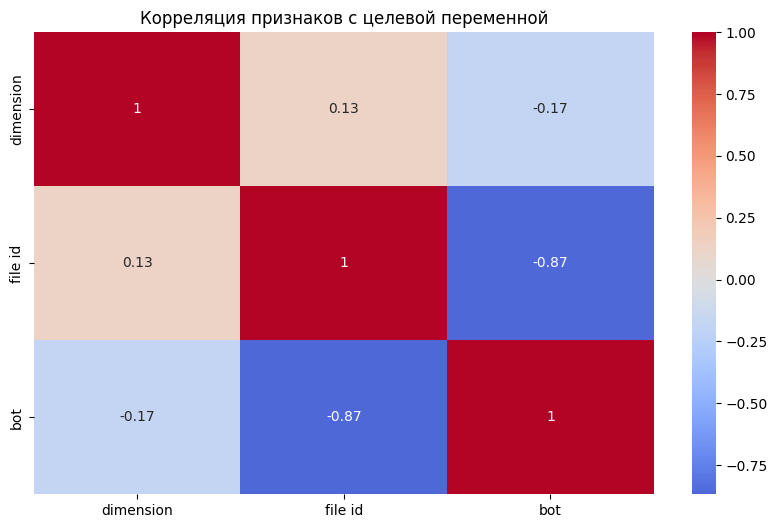

In [ ]:
corr = df.corr()

# построение heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Корреляция признаков с целевой переменной")
plt.show()

In [53]:
mask_4 = df['file id'] == 4
df_4 = df[mask_4]
df_not_4 = df[~mask_4]

df_4_train = df_4.iloc[:len(df_4) // 2]
df_4_test = df_4.iloc[len(df_4) // 2:]

# формируем train и test

# file id train
train = pd.concat([
    df_not_4[df_not_4['file id'].isin([0, 1])],
    df_4_train
])

# file id test
test = pd.concat([
    df_not_4[df_not_4['file id'].isin([2, 3])],
    df_4_test
])

In [54]:
X_train = train.drop(columns=['file id', 'bot'])
y_train = train['bot'].values

X_test = test.drop(columns=['file id', 'bot'])
y_test = test['bot'].values

## KNN

              precision    recall  f1-score   support

           0       0.59      0.85      0.70       793
           1       0.72      0.38      0.50       772

    accuracy                           0.62      1565
   macro avg       0.65      0.62      0.60      1565
weighted avg       0.65      0.62      0.60      1565



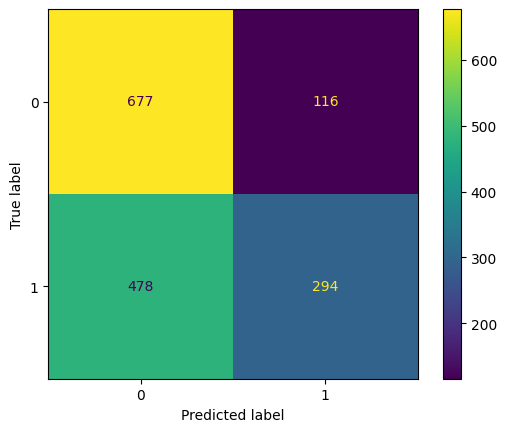

In [ ]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

matrix1 = confusion_matrix(y_test, y_pred, normalize=None)
disp1 = ConfusionMatrixDisplay(confusion_matrix=matrix1)
disp1.plot()

## AdaBoostClassifier

              precision    recall  f1-score   support

           0       0.58      0.88      0.70       793
           1       0.74      0.35      0.48       772

    accuracy                           0.62      1565
   macro avg       0.66      0.62      0.59      1565
weighted avg       0.66      0.62      0.59      1565



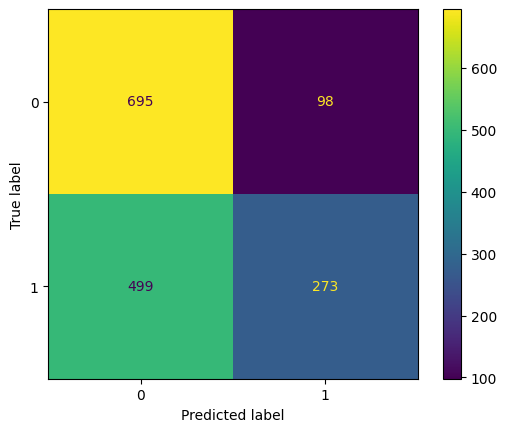

In [55]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

y_pred = ada.predict(X_test)
print(classification_report(y_test, y_pred))

matrix1 = confusion_matrix(y_test, y_pred, normalize=None)
disp1 = ConfusionMatrixDisplay(confusion_matrix=matrix1)
disp1.plot()

## SVC

              precision    recall  f1-score   support

           0       0.58      0.92      0.71       793
           1       0.78      0.31      0.44       772

    accuracy                           0.62      1565
   macro avg       0.68      0.61      0.57      1565
weighted avg       0.68      0.62      0.58      1565



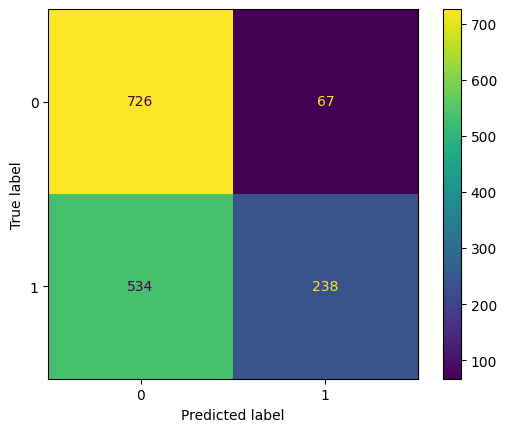

In [ ]:
svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))

matrix1 = confusion_matrix(y_test, y_pred, normalize=None)
disp1 = ConfusionMatrixDisplay(confusion_matrix=matrix1)
disp1.plot()

## LogisticRegression

              precision    recall  f1-score   support

           0       0.57      0.90      0.70       793
           1       0.74      0.29      0.42       772

    accuracy                           0.60      1565
   macro avg       0.65      0.60      0.56      1565
weighted avg       0.65      0.60      0.56      1565



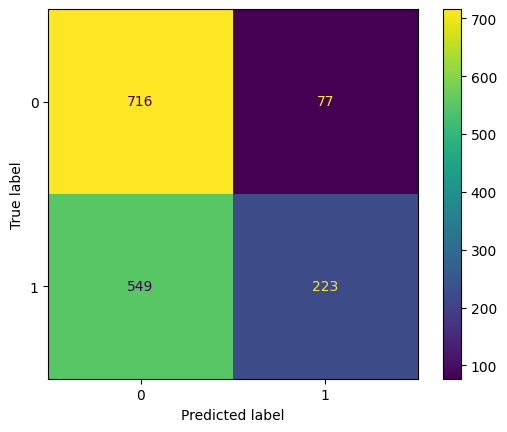

In [ ]:
logistic_regression = LogisticRegression(C=1)
logistic_regression.fit(X_train, y_train)

y_pred = logistic_regression.predict(X_test)
print(classification_report(y_test, y_pred))

matrix1 = confusion_matrix(y_test, y_pred, normalize=None)
disp1 = ConfusionMatrixDisplay(confusion_matrix=matrix1)
disp1.plot()